In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import pickle
from functools import reduce
from dateutil.relativedelta import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#import sys 
#sys.path.append('D:/sciebo/Montreal/Code/')
#sys.path.append('D:/sciebo/Montreal/Code/ERC_data_helpers/')
#import ERC_data_helpers as ERC

In [2]:
from helpers import load, plot

In [3]:
plot.ERC_Management().set_plot_params()
fig_width = 6.33
linewidth=.75

colordict = {'Tin_M': '#4474A2', 'Tout_M': '#70CAE6', 'Vdot': 
'#BABABA'}

In [4]:
## Load data
start_date = '2022-06-24 01:00:00' #gut um nans zu zeigen
end_date = '2022-07-24 02:05:00'
probe = '40'
#data = load.load_raw_data(start_date, end_date, BHEs = probe, masked=False)
data = load.load_data(start_date, end_date, masked=False, data_type='raw')
#data.index = pd.to_datetime(data.index)

(<Figure size 3000x750 with 2 Axes>,
 <Axes: title={'center': 'Data of BHE 40'}, ylabel='Temperature (°C)'>)

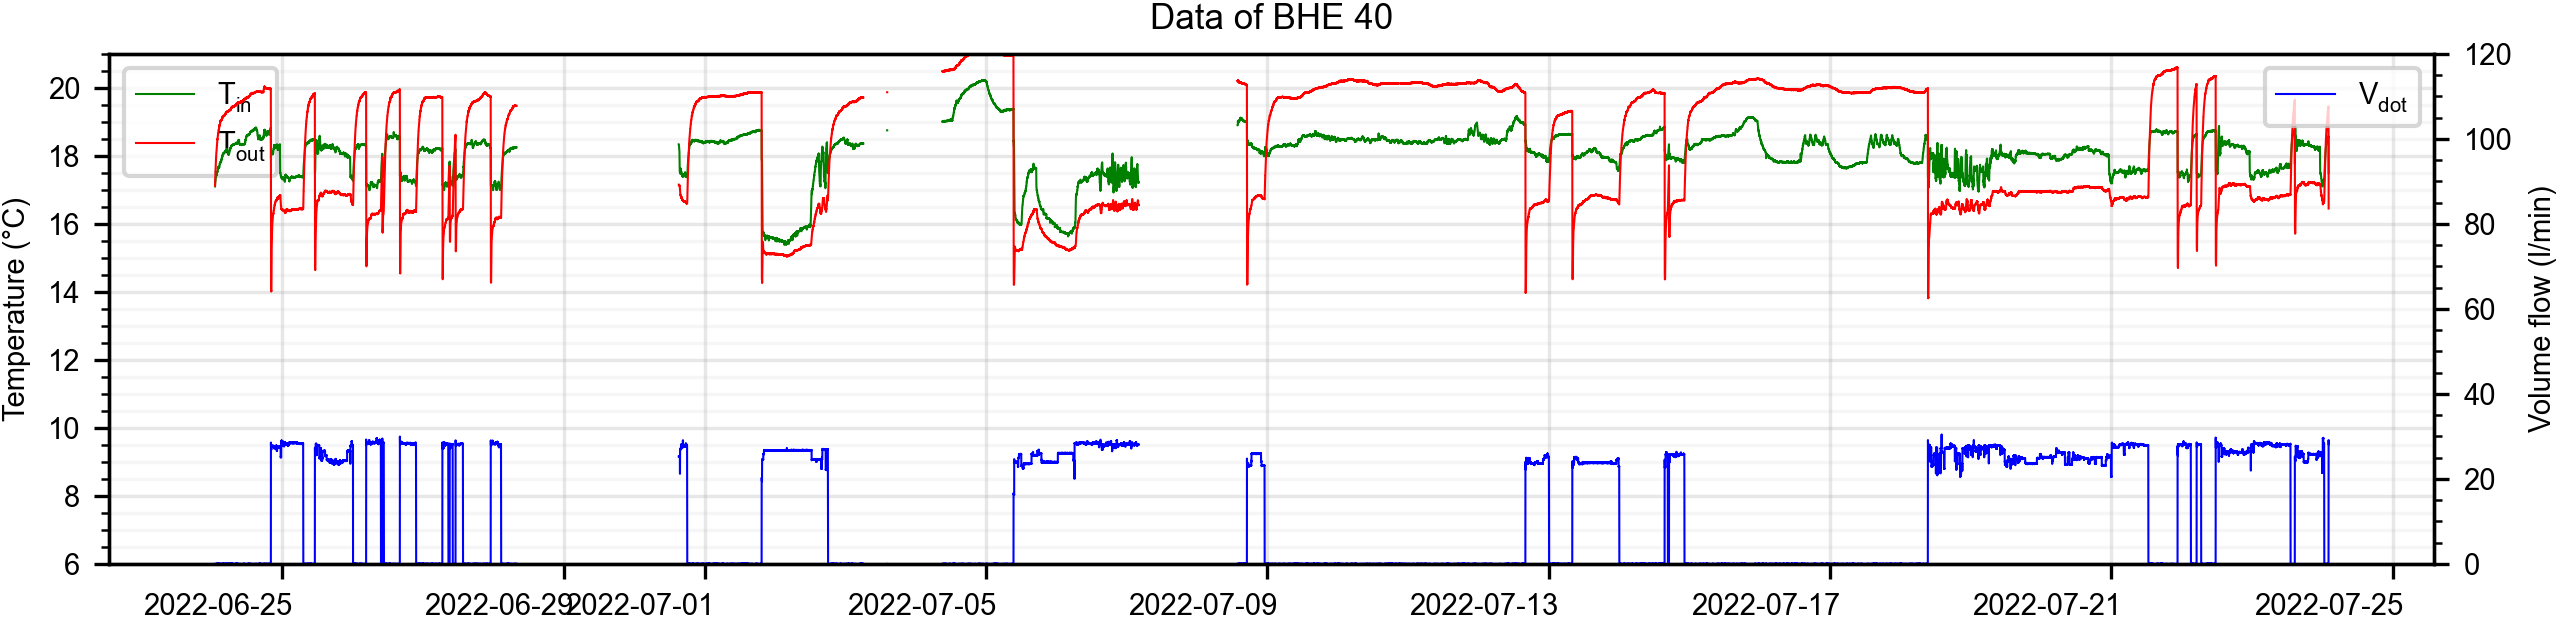

In [9]:
plot.plot_one_BHE(data, probe)

In [10]:
mask = load.create_BHE_data_mask(data, probe)
data.loc[mask, [f'Probe_{probe}_T_in', f'Probe_{probe}_T_out', f'Probe_{probe}_V_dot']] = np.nan 

(<Figure size 3000x750 with 2 Axes>,
 <Axes: title={'center': 'Data of BHE 40'}, ylabel='Temperature (°C)'>)

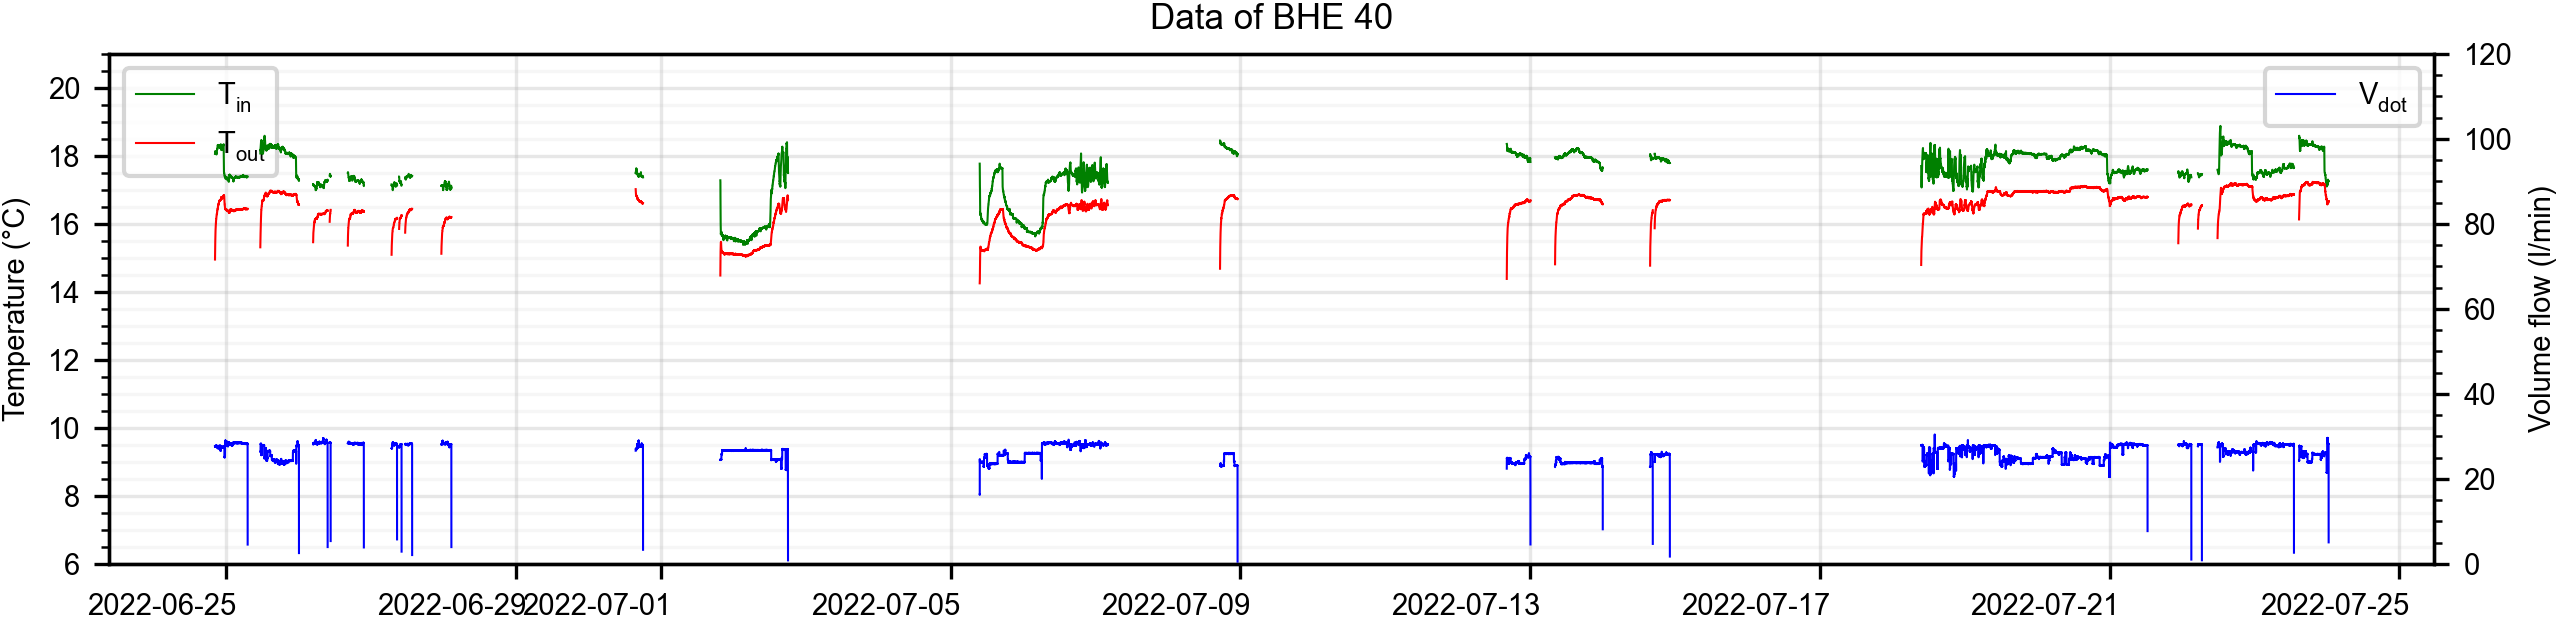

In [11]:
plot.plot_one_BHE(data, probe)

### Just for the plot

In [5]:
## Load data
start_date = '2022-07-01 01:00:00' #gut um nans zu zeigen
end_date = '2022-07-30 02:05:00'
probe = '40'
data = load.load_data(start_date, end_date, BHEs = probe, data_type='raw', masked=False)

In [6]:
# Number of steps to mask after encountering a NaN or zero
time_to_mask = 747
timestep = 30
nsteps = -(-time_to_mask // timestep) # rounds up to the next integer
min_gap_size = 20

# Initialize the boolean mask
mask = np.zeros_like(data[f'Probe_{probe}_T_in'].values, dtype=bool)

# Create zero volflow mask
mask_volflow = data[f'Probe_{probe}_V_dot'].values < 1

#### Create a boolean mask for no data volflow
mask_nan_volflow = np.zeros_like(data[f'Probe_{probe}_V_dot'].values, dtype=bool)

# Find the start and end of NaN sequences
nan_diff = np.diff(np.concatenate(([0], np.isnan(data[f'Probe_{probe}_V_dot'].values), [0])))
nan_starts = np.where(nan_diff == 1)[0]
nan_ends = np.where(nan_diff == -1)[0]

# Apply the condition for NaN sequences longer than min_gap_size, plus the next nsteps positions
for start, end in zip(nan_starts, nan_ends):
    if end - start > min_gap_size:
        mask_nan_volflow[start:min(end + nsteps, len(data[f'Probe_{probe}_V_dot'].values))] = True
### End creation boolean mask nodata volflow

# Combine both conditions
combined_mask = mask_nan_volflow | mask_volflow
# Find indices where combined_mask is True
indices = np.where(combined_mask)[0]
# Set mask to True for these indices and the next nsteps
for idx in indices:
    mask[idx:idx + nsteps + 1] = True
# Ensure the mask does not go out of bounds
mask = mask[:len(data[f'Probe_{probe}_T_in'].values)]


In [7]:
from matplotlib.transforms import ScaledTranslation
import matplotlib.dates as mdates 

In [8]:
from helpers import load, plot, analyse 
fig_width = 6.33
plot.ERC_Management().set_plot_params()

meta NOT subset; don't know how to subset; dropped


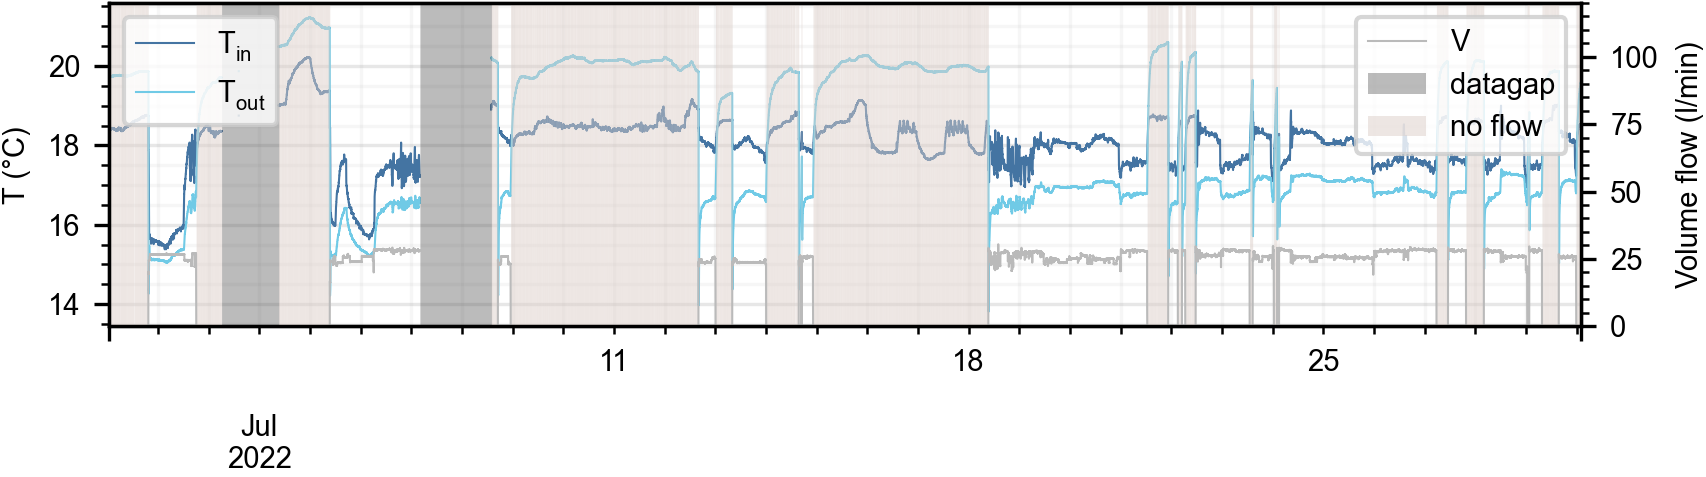

In [9]:
colors= ['#4474A2', '#70CAE6']
linewidth=.5

all_color_dict = plot.ERC_Management().create_colordict(probe_strings=False)
titlestr = ''
fig, ax = plt.subplots(1,1,figsize=(fig_width, 1.4), dpi=300)
ax2 = ax.twinx()

data.plot(ax=ax, y = f'Probe_{probe}_T_in', linewidth=linewidth, color=colors[0], label='$\mathregular{T_{in}}$')
data.plot(ax=ax, y = f'Probe_{probe}_T_out', linewidth=linewidth, color=colors[1], label='$\mathregular{T_{out}}$')
data.plot(ax=ax2, y= f'Probe_{probe}_V_dot', linewidth=linewidth, color='#BABABA', label='$\mathregular{V}$')

vdot_ymax = 120

ax2.fill_between(data.index, mask_nan_volflow*vdot_ymax, alpha=.4, label='datagap', color='#555555', zorder=-10, linewidth=0)
ax2.fill_between(data.index, mask_volflow*vdot_ymax, label='no flow', color='#ddcfc9', alpha=.5, zorder=-10, linewidth=0)

ax2.legend(loc='upper right')
ax.legend(loc='upper left')

# Re-arrange legends to last axis
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
        
ax.set_xlim(start_date, end_date)
#ax.set_title(f' Masking of BHE {probe}')

ax2.set_ylim(0,120)
ax2.set_ylabel('Volume flow (l/min)')

ax.grid(alpha=.3, which='major')
ax.grid(alpha=.1, which='minor')
ax.set_ylabel('T (°C)')
ax.set_xlabel('')
plt.savefig(f'Masking_BHE_{probe}.pdf', bbox_inches='tight')

(19181.5, 19182.0)

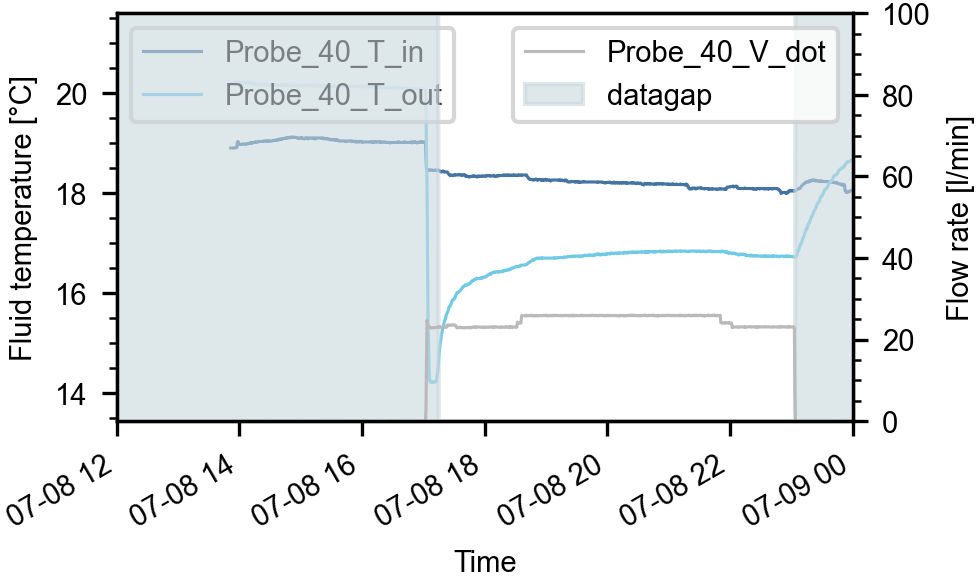

In [56]:
fig, ax = plt.subplots(1,1,figsize=(fig_width/2, 2), dpi=300)
ax2 = ax.twinx()

data.plot(ax=ax, y = f'Probe_{probe}_T_in', linewidth=linewidth, color=colors[0])
data.plot(ax=ax, y = f'Probe_{probe}_T_out', linewidth=linewidth, color=colors[1])
data.plot(ax=ax2, y= f'Probe_{probe}_V_dot', linewidth=linewidth, color='#BABABA')

ax.legend(loc='upper left')
ax.set_ylabel('Fluid temperature (°C)')

vdot_ymax = 100
ax2.set_ylim(0,vdot_ymax)
ax2.set_ylabel('Flow rate (l/min)')

ax2.fill_between(data.index, mask*vdot_ymax, alpha=.6, label='masked', color='#c9d7dd')
ax2.legend(loc='upper right')
ax.set_xlim('2022-07-08 12:00:00', '2022-07-09 00:00:00')